In [ ]:
import os, torch, torchvision, random, copy
import pandas as pd
import numpy as np
import cv2
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.cluster import KMeans, DBSCAN

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torchsummary import summary

In [ ]:
if not os.path.isdir('/content/Train_Dev'):
  !unzip ./drive/MyDrive/Train_Dev.zip
else:
  print('/content/Train_Dev already exist')

Archive:  ./drive/MyDrive/Train_Dev.zip
   creating: Train_Dev/
   creating: Train_Dev/development/
  inflating: Train_Dev/development/DSC080453.JPG  
  inflating: Train_Dev/development/DSC080632.JPG  
  inflating: Train_Dev/development/DSC080634.JPG  
  inflating: Train_Dev/development/DSC080714.JPG  
  inflating: Train_Dev/development/DSC080743.JPG  
  inflating: Train_Dev/development/DSC080824.JPG  
  inflating: Train_Dev/development/DSC081021.JPG  
  inflating: Train_Dev/development/DSC081023.JPG  
  inflating: Train_Dev/development/DSC081081.JPG  
  inflating: Train_Dev/development/DSC081102.JPG  
  inflating: Train_Dev/development/DSC081131.JPG  
  inflating: Train_Dev/development/DSC081542.JPG  
  inflating: Train_Dev/development/DSC081684.JPG  
  inflating: Train_Dev/development/DSC081692.JPG  
  inflating: Train_Dev/development/DSC082011.JPG  
  inflating: Train_Dev/development/DSC082014.JPG  
  inflating: Train_Dev/development/DSC082141.JPG  
  inflating: Train_Dev/developmen

In [ ]:
if not os.path.isdir('/content/outputImage48'):
  !unzip ./drive/MyDrive/outputImage48.zip
else:
  print('/content/output_Image48 already exist')

Archive:  ./drive/MyDrive/outputImage48.zip
   creating: outputImage48/
  inflating: outputImage48/DSC080694.JPG  
  inflating: outputImage48/DSC080814.JPG  
  inflating: outputImage48/DSC081022.JPG  
  inflating: outputImage48/DSC081681.JPG  
  inflating: outputImage48/DSC081682.JPG  
  inflating: outputImage48/DSC081693.JPG  
  inflating: outputImage48/DSC081724.JPG  
  inflating: outputImage48/DSC081871.JPG  
  inflating: outputImage48/DSC082761.JPG  
  inflating: outputImage48/DSC082764.JPG  
  inflating: outputImage48/DSC082791.JPG  
   creating: outputImage48/outputImage48/


In [ ]:
image_pathes = [os.path.join('/content/Train_Dev/training', fn) for fn in os.listdir('/content/Train_Dev/training')]
label_pathes = [os.path.join('/content/Train_Dev/train_labels', fn) for fn in os.listdir('/content/Train_Dev/train_labels')]
test_pathes = [os.path.join('/content/Train_Dev/development', fn) for fn in os.listdir('/content/Train_Dev/development')]

image_21_pathes = [fp for fp in image_pathes if 'RGB' in fp]
image_48_pathes = [fp for fp in image_pathes if not 'RGB' in fp]

label_21_pathes = [fp for fp in label_pathes if 'RGB' in fp]
label_48_pathes = [fp for fp in label_pathes if not 'RGB' in fp]

test_21_pathes = [fp for fp in test_pathes if 'RGB' in fp]
test_48_pathes = [fp for fp in test_pathes if not 'RGB' in fp]

image_21_pathes.sort()
image_48_pathes.sort()
label_21_pathes.sort()
label_48_pathes.sort()
test_21_pathes.sort()
test_48_pathes.sort()

In [ ]:
import shutil

def read_label(lpath):

  labels = []

  with open(lpath, 'r', encoding='utf-8') as f:
      lines = f.readlines()
  for line in lines:
      x, y = tuple(line.strip().split(','))
      labels.append((int(x),int(y)))

  return labels

def cut_image(ipathes, lpathes, outdir='/content/subimages'):
       
  if os.path.isdir(outdir):
    shutil.rmtree(outdir)
  os.mkdir(outdir)
  stride = (100, 100)

  for ipath, lpath in zip(ipathes, lpathes):
    img = Image.open(ipath)
    img_fn = ipath.split('/')[-1].split('.')[0]
    labels = np.array(read_label(lpath))
    for i in range(0, img.size[0], stride[0]):
      for j in range(0, img.size[1], stride[1]):
        
        outifp = os.path.join(outdir, '{}_{}_{}.JPG'.format(img_fn, i, j))
        img.crop((i, j, i+stride[0], j+stride[0])).save(outifp)

        outlfp = os.path.join(outdir, '{}_{}_{}.txt'.format(img_fn, i, j))
        
        with open(outlfp, 'w') as fout:
          for label in labels:
            if label[0] >= i and label[0] <= i + stride[0]:
              if label[1] >= j and label[1] <= j + stride[1]:
                fout.write('{}, {}\n'.format(label[0], label[1]))

In [ ]:
# masked_ifp, masked_lfp = zip(*masked_tups)

cut_image(ipathes=image_48_pathes, lpathes=label_48_pathes)

In [ ]:
sub_images = [os.path.join('/content/subimages', fn) for fn in os.listdir('/content/subimages') if fn.endswith('JPG')]
sub_labels = [os.path.join('/content/subimages', fn) for fn in os.listdir('/content/subimages') if fn.endswith('txt')]
sub_images.sort()
sub_labels.sort()

for sub_img, sub_lab in zip(sub_images, sub_labels):
  with open(sub_lab, 'r') as f:
    if len(f.readlines()) == 0:
      repeat_ipath = sub_img.split('.')[0] + 'HF.JPG'
      repeat_lpath = sub_lab.split('.')[0] + 'HF.txt'
      Image.open(sub_img).transpose(Image.FLIP_LEFT_RIGHT).save(repeat_ipath)
      with open(repeat_lpath, 'w') as fout:
        fout.write('')

FileNotFoundError: ignored

In [ ]:
sub_images = [os.path.join('/content/subimages', fn) for fn in os.listdir('/content/subimages') if fn.endswith('JPG')]
sub_labels = [os.path.join('/content/subimages', fn) for fn in os.listdir('/content/subimages') if fn.endswith('txt')]
sub_images.sort()
sub_labels.sort()

cnts = []
for sub_lab in sub_labels:
  with open(sub_lab, 'r') as f:
    cnts.append(1 if len(f.readlines()) > 0 else 0)

print(sum(cnts))
print(len(cnts)-sum(cnts))

In [ ]:
import random

'''
check if label is in the range of the box
'''
def label_in_range(label, box=(0,0,150,150), ex=20):

  if label[0] >= box[0]-ex and label[0] <= box[2]+ex:
    if label[1] >= box[1]-ex and label[1] <= box[3]+ex:
      return True

  return False

def RandomCrop(ifp, lfp, figsize=(150,150)):

  # load image and labels
  img = Image.open(ifp)
  labels = read_label(lfp)

  randx, randy = random.randint(0, img.size[0]-figsize[0]-1), random.randint(0, img.size[1]-figsize[1]-1)

  crop_img = img.crop((randx, randy, randx+figsize[0], randy+figsize[1]))


  crop_labels = []

  for label in labels:
    if label_in_range(label, (randx, randy, randx+figsize[0], randy+figsize[1])):
      new_label = (label[0]-randx, label[1]-randy)
      crop_labels.append(new_label)

  return crop_img, crop_labels

def RandomCropContour(img, mask, figsize=(300,300)):

  randx, randy = random.randint(0, img.size[0]-figsize[0]-1), random.randint(0, img.size[1]-figsize[1]-1)

  crop_img = img.crop((randx, randy, randx+figsize[0], randy+figsize[1]))
  crop_label = mask[randy:min(randy+figsize[1], img.size[1]), randx:min(randx+figsize[0], img.size[0])]

  return crop_img, crop_label

In [ ]:
class RiceDataset(Dataset):

    def __init__(self, filenames, labels, transform):

        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):

        return len(self.filenames)

    def __getitem__(self, idx):

        # img, label = RandomCrop(self.filenames[idx], self.labels[idx])
        image = self.transform(Image.open(self.filenames[idx]))
        label = read_label(self.labels[idx])

        return image, 1 if len(label) > 0 else 0

        # return image, len(label)

In [ ]:
# print(os.listdir('/content/subimages'))
cnts = []
for fn in os.listdir('/content/subimages'):
  if fn.endswith('txt'):
    with open(os.path.join('/content/subimages', fn), 'r') as f:
      cnts.append(1 if len(f.readlines()) > 0 else 0)

print(sum(cnts))
print(len(cnts) - sum(cnts))

11459
7082


In [ ]:
batch_size = 224

train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(180),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5]),
])

test_transformer = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5]),
])

def split_Train_Val_Data(data_dir = '/content/subimages'):

    inputs, labels = [], []

    for filename in os.listdir(data_dir):

      if filename.endswith('JPG'):
        inputs.append(os.path.join(data_dir, filename))
      else:
        labels.append(os.path.join(data_dir, filename.split('.')[0]+'.txt'))

    inputs.sort()
    labels.sort()

    inputs_0, inputs_1 = [], []
    labels_0, labels_1 = [], []

    for input, label in zip(inputs, labels):
      with open(label, 'r') as f:
        if len(f.readlines()) > 0:
          inputs_1.append(input)
          labels_1.append(label)
        else:
          inputs_0.append(input)
          labels_0.append(label)

    inputs_0, labels_0 = np.asarray(inputs_0), np.asarray(labels_0)
    inputs_1, labels_1 = np.asarray(inputs_1), np.asarray(labels_1)

    train_inputs, test_inputs = [], []
    train_labels, test_labels = [], []

    np.random.seed(69)

    idxs_0 = list(range(len(inputs_0)))
    idxs_1 = list(range(len(inputs_1)))

    np.random.shuffle(idxs_0)
    np.random.shuffle(idxs_1)
    
    mid_0 = int(len(idxs_0)*0.95)
    mid_1 = int(len(idxs_1)*0.95)

    train_inputs.extend(inputs_0[idxs_0[:mid_0]])
    train_inputs.extend(inputs_1[idxs_1[:mid_1]])

    train_labels.extend(labels_0[idxs_0[:mid_0]])
    train_labels.extend(labels_1[idxs_1[:mid_1]])

    test_inputs.extend(inputs_0[idxs_0[mid_0:]])
    test_inputs.extend(inputs_1[idxs_1[mid_1:]])

    test_labels.extend(labels_0[idxs_0[mid_0:]])
    test_labels.extend(labels_1[idxs_1[mid_1:]])

    train_dataloader = DataLoader(RiceDataset(train_inputs, train_labels, train_transformer), batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(RiceDataset(test_inputs, test_labels, test_transformer), batch_size = batch_size, shuffle = False)

    return train_dataloader, test_dataloader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class RiceCount(torch.nn.Module):
  
  def __init__(self):

    super().__init__()

    # ----------------------------------------------
    # 初始化模型的 layer (input size: 224 * 224)

    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6,6))
    self.regressor = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 2048),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(2048, 2048),
        nn.ReLU(),
        nn.Linear(2048, 2)
    )

    # ----------------------------------------------
            
  def forward(self, x):
    
    # ----------------------------------------------
    # Forward (final output 1 probability)

    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.regressor(x)
    # x = torch.round(x)

    # ----------------------------------------------

    return x

In [ ]:
train_dataloader, test_dataloader = split_Train_Val_Data()

C = RiceCount().to(device)

lr = 1e-2
m = 0.9
wd = 0.01

optimizer_C = optim.SGD(C.parameters(), lr = lr, momentum = m, weight_decay = wd) # 選擇你想用的 optimizer

summary(C, (3, 224 ,224)) # 利用 torchsummary 的 summary package 印出模型資訊，input size: (224 * 224)

# Loss function
# criteron = nn.MSELoss() # 選擇想用的 loss function
criteron = nn.CrossEntropyLoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
        MaxPool2d-11            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-12            [-1, 256, 6, 6]               0
          Dropout-13                 [-1, 9216]               0
           Linear-14                 [-

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
train_acc = []
test_acc = []
loss_epoch_C = []

In [ ]:
epochs = 50

for epoch in range(epochs):

  ##########################
  # dont execute here
  # break
  ##########################

  iter = 0
  correct_train, total_train = 0, 0
  correct_test, total_test = 0, 0
  train_loss_C = 0.0

  C.train() # 設定 train 或 eval

  print('epoch: ' + str(epoch + 1) + ' / ' + str(epochs))  
  
  # ---------------------------
  # Training Stage
  # ---------------------------
  
  for i, (x, label) in enumerate(train_dataloader) :
                
    x, label = x.to(device), label.to(device)
                
    optimizer_C.zero_grad() # 清空梯度
    
    outputs = C(x) # 將訓練資料輸入至模型進行訓練
    # print(outputs)

    loss = criteron(outputs, label.long()) # 計算 loss
    
    loss.backward() # 將 loss 反向傳播
    optimizer_C.step() # 更新權重
    
    # 計算訓練資料的準確度 (correct_train / total_train)
    _, predicted = torch.max(outputs, 1)
    total_train += label.size(0)
    correct_train += (predicted == label).sum().item()

    train_loss_C += loss.item()
    iter += 1
              
  print('Training epoch: %d / loss_C: %.3f | acc: %.3f' % \
        (epoch + 1, train_loss_C / iter, correct_train / total_train))

  
  # --------------------------
  # Testing Stage
  # --------------------------
  
  C.eval() # 設定 train 或 eval
    
  for i, (x, label) in enumerate(test_dataloader) :
    
    with torch.no_grad(): # 測試階段不需要求梯度
      x, label = x.to(device), label.to(device)
      
      outputs = C(x) # 將測試資料輸入至模型進行測試 
      
      _, predicted = torch.max(outputs, 1)
      total_test += label.size(0)
      correct_test += (predicted == label).sum().item()
  
  print('Testing acc: %.3f' % (correct_test / total_test))
  train_acc.append(100 * correct_train/total_train) # training accuracy
  test_acc.append(100 * correct_test/total_test)  # testing accuracy
  loss_epoch_C.append(train_loss_C) # loss

epoch: 1 / 50
Training epoch: 1 / loss_C: 0.668 | acc: 0.613
Testing acc: 0.617
epoch: 2 / 50
Training epoch: 2 / loss_C: 0.664 | acc: 0.618
Testing acc: 0.617
epoch: 3 / 50
Training epoch: 3 / loss_C: 0.656 | acc: 0.618
Testing acc: 0.617
epoch: 4 / 50
Training epoch: 4 / loss_C: 0.619 | acc: 0.703
Testing acc: 0.791
epoch: 5 / 50
Training epoch: 5 / loss_C: 0.572 | acc: 0.775
Testing acc: 0.807
epoch: 6 / 50
Training epoch: 6 / loss_C: 0.553 | acc: 0.748
Testing acc: 0.796
epoch: 7 / 50
Training epoch: 7 / loss_C: 0.500 | acc: 0.774
Testing acc: 0.805
epoch: 8 / 50
Training epoch: 8 / loss_C: 0.401 | acc: 0.828
Testing acc: 0.874
epoch: 9 / 50
Training epoch: 9 / loss_C: 0.316 | acc: 0.875
Testing acc: 0.898
epoch: 10 / 50
Training epoch: 10 / loss_C: 0.299 | acc: 0.883
Testing acc: 0.912
epoch: 11 / 50
Training epoch: 11 / loss_C: 0.284 | acc: 0.890
Testing acc: 0.914
epoch: 12 / 50
Training epoch: 12 / loss_C: 0.265 | acc: 0.898
Testing acc: 0.911
epoch: 13 / 50
Training epoch: 13 

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'accuracy')

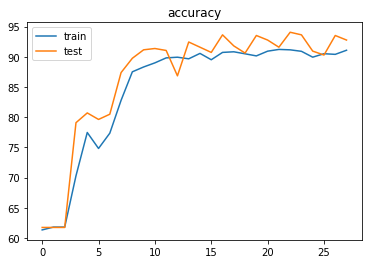

In [ ]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(['train', 'test'])
plt.title('accuracy')

Text(0.5, 1.0, 'Loss')

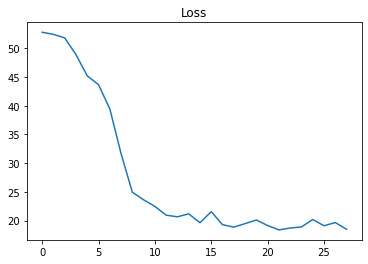

In [ ]:
plt.plot(loss_epoch_C)
plt.title('Loss')

In [ ]:
C = torch.load('/content/best224.pt', map_location=torch.device('cpu'))

FileNotFoundError: ignored

In [ ]:
dev_imgs = [os.path.join('/content/Train_Dev/development', fn) for fn in os.listdir('/content/Train_Dev/development') if not 'RGB' in fn]

/content/Train_Dev/training/DSC080814.JPG


(2000.0, 0.0)

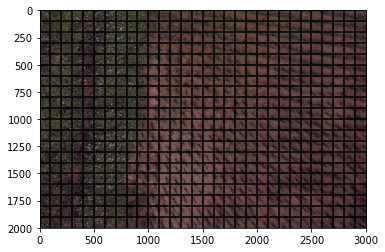

In [ ]:
stride = (100,100)
selected_path = image_48_pathes[3]
demo_img = Image.open(selected_path)
print(selected_path)
# demo_img = Image.open(dev_imgs[1])
# demo_img = Image.open(r'/content/Train_Dev/training/DSC082791.JPG')
# demo_img = Image.open(r'/content/Train_Dev/training/DSC081681.JPG')

result_map = np.zeros(demo_img.size[::-1])

C.eval()

plt.figure(figsize=(20,20))

for i in range(0, demo_img.size[0], stride[0]):
  for j in range(0, demo_img.size[1], stride[1]):
    
    input_img = demo_img.crop((i,j,i+stride[0],j+stride[1]))
    input_img = TF.resize(input_img, [224, 224])
    input_img = TF.pil_to_tensor(input_img).float()

    outputs = C(input_img.unsqueeze(0).to(device))
    _, predicted = torch.max(outputs, 1)
    result_map[j:j+stride[1], i:i+stride[0]] = predicted.cpu()
    # print(i,j)

plt.imshow(demo_img)
plt.imshow(result_map, alpha=0.3)

for i in range(0, demo_img.size[0], stride[0]):
  plt.vlines(i, 0, 2000)

for j in range(0, demo_img.size[1], stride[1]):
  plt.hlines(j, 0, 3000)

plt.xlim(0, 3000)
plt.ylim(2000, 0)

In [ ]:
# np.unique(result_map)
# ls = read_label(lpath=label_48_pathes[1])

# plt.imshow(demo_img)
# for l in ls:
#   plt.plot(*l, 'r+')

In [ ]:
# torch.save(C, '/content/best.pt')

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=5, random_state=0)

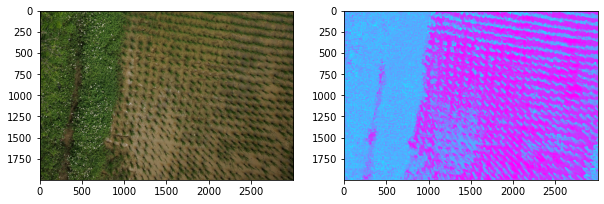

In [ ]:
# img = Image.open(r'/content/outputImage48/DSC081693.JPG')
img = demo_img
ground_truth = read_label(label_48_pathes[2])


box = (0, 0, 100, 100)
sub_img = img.crop(box)

X = np.array(img).reshape(img.size[0]*img.size[1], 3)
kmeans.fit(X)

pred_img = kmeans.predict(X).reshape(img.size[1], img.size[0])

fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[1].imshow(pred_img, cmap='cool')

ax[0].imshow(img)

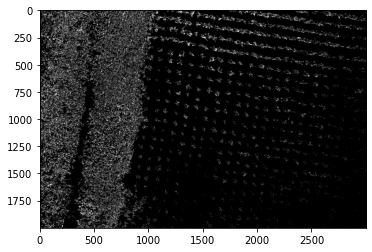

In [ ]:
bin_map = np.where(pred_img==0, 1, 0)
plt.imshow(bin_map, cmap='gray')

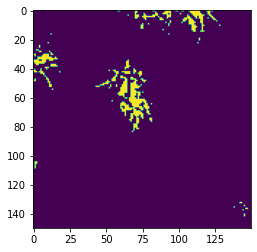

In [ ]:
sub_bin_map = bin_map[0:150, 0:150]
sub_bin_map = bin_map[300:450, 300:450]
sub_img = np.array(img)[300:450, 300:450]
plt.imshow(sub_bin_map)

rice_area = []

for i in range(150):
  for j in range(150):
    if sub_bin_map[i, j] == 1:
      rice_area.append((j, i))

Text(0, 0.5, 'Silhouette score')

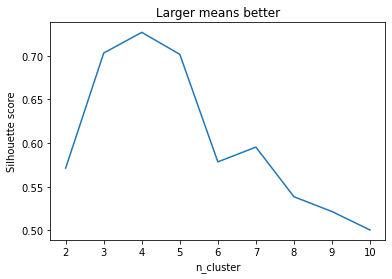

In [ ]:
sil = []
kmax = 10

sub_X = np.array(rice_area)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(sub_X)
  labels = kmeans.labels_
  sil.append(silhouette_score(sub_X, labels, metric = 'euclidean'))

plt.title('Larger means better')
plt.plot(np.array(range(len(sil)))+2, sil)
plt.xlabel('n_cluster')
plt.ylabel('Silhouette score')

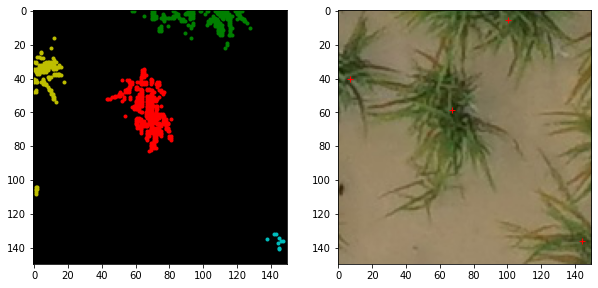

In [ ]:
best_n = np.argmax(sil)+2
lkmeans = KMeans(n_clusters=best_n, random_state=10)

sub_X = np.array(rice_area)
lkmeans.fit(sub_X)
results = lkmeans.predict(sub_X)

fig, ax = plt.subplots(1,2, figsize=(10,7))

ax[0].imshow(np.zeros(sub_img.shape))
for result, sub_x in zip(results, sub_X):
  mark = ['r.', 'g.', 'y.', 'c.', 'b.', 'r+', 'g+', 'y+', 'c+']
  ax[0].plot(sub_x[0], sub_x[1], mark[result])

ax[1].imshow(sub_img)
for k in list(set(results)):
  gropu_k = sub_X[results==k]
  ax[1].plot(np.mean(gropu_k[:,0]), np.mean(gropu_k[:,1]), 'r+')

In [ ]:
cluster_mids = []

for i in range(0, 2000, 200):
  for j in range(0, 3000, 150):
    sub_bin_map = bin_map[i:i+200, j:j+150]
    rice_area = []

    for i1 in range(200):
      for j1 in range(150):
        if sub_bin_map[i1, j1] == 1:
          rice_area.append((j1, i1))

    sil = []
    kmax = 10

    sub_X = np.array(rice_area)

    if sub_X.size == 0:
      continue

    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+1):
      kmeans = KMeans(n_clusters = k).fit(sub_X)
      labels = kmeans.labels_
      if len(labels) == k:
        break
      sil.append(silhouette_score(sub_X, labels, metric = 'euclidean'))


    best_n = np.argmax(sil)+2
    lkmeans = KMeans(n_clusters=best_n, random_state=10)

    lkmeans.fit(sub_X)
    results = lkmeans.predict(sub_X)

    for k in list(set(results)):
      gropu_k = sub_X[results==k]
      cluster_mids.append((np.mean(gropu_k[:,0])+j, np.mean(gropu_k[:,1])+i))

ValueError: ignored

In [ ]:
# cluster_mids = []
# with open('/content/rf48_0.csv', 'r') as f:
#   for line in f.readlines():
#     x, y = line.strip().split(',')
#     cluster_mids.append((float(x), float(y)))

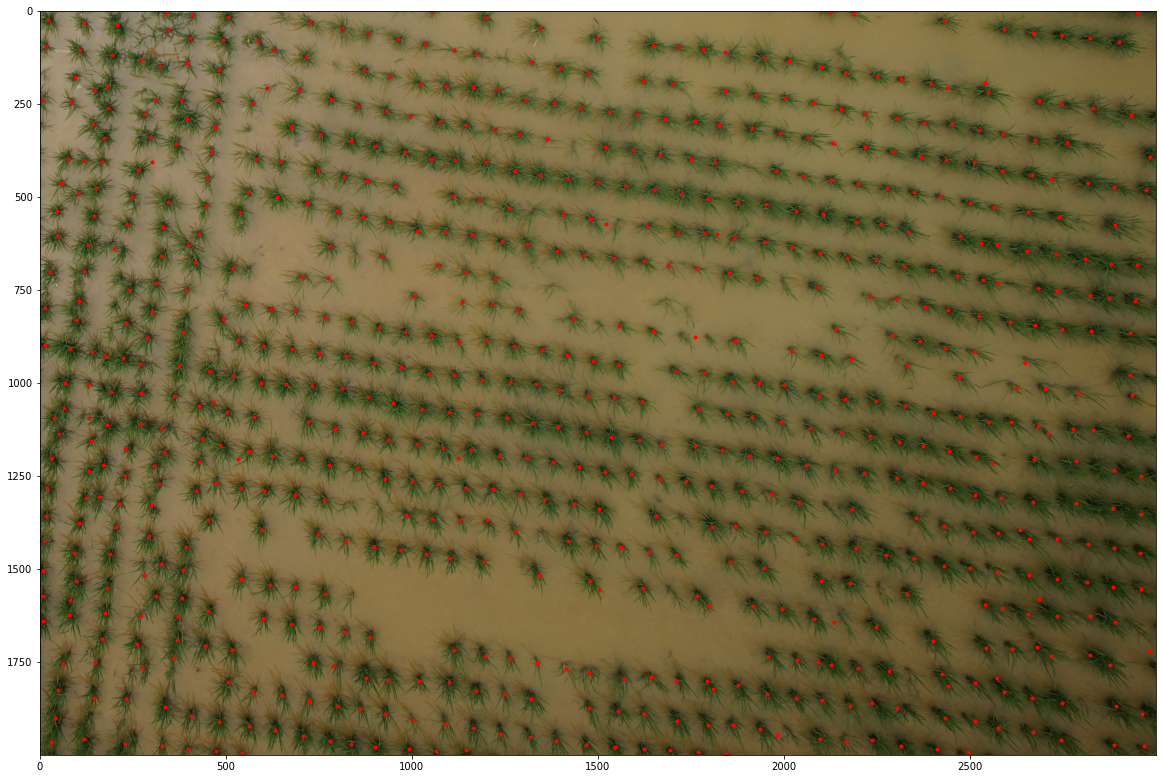

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(img)
for cluster_mid in cluster_mids:
  plt.plot(cluster_mid[0], cluster_mid[1], 'r.')

In [ ]:
def reduction(mids, thresh=20):

  # no replication
  bag = list(set(mids))

  dist = lambda a, b: np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
  output_bag = []

  while len(bag) != 0:

    too_close_points = [point for point in bag if dist(point, bag[0]) < thresh]
    
    for point in too_close_points:
      bag.remove(point)
    
    too_close_points = np.array(too_close_points)
    output_bag.append((np.mean(too_close_points[:,0]), np.mean(too_close_points[:,1])))

  return output_bag

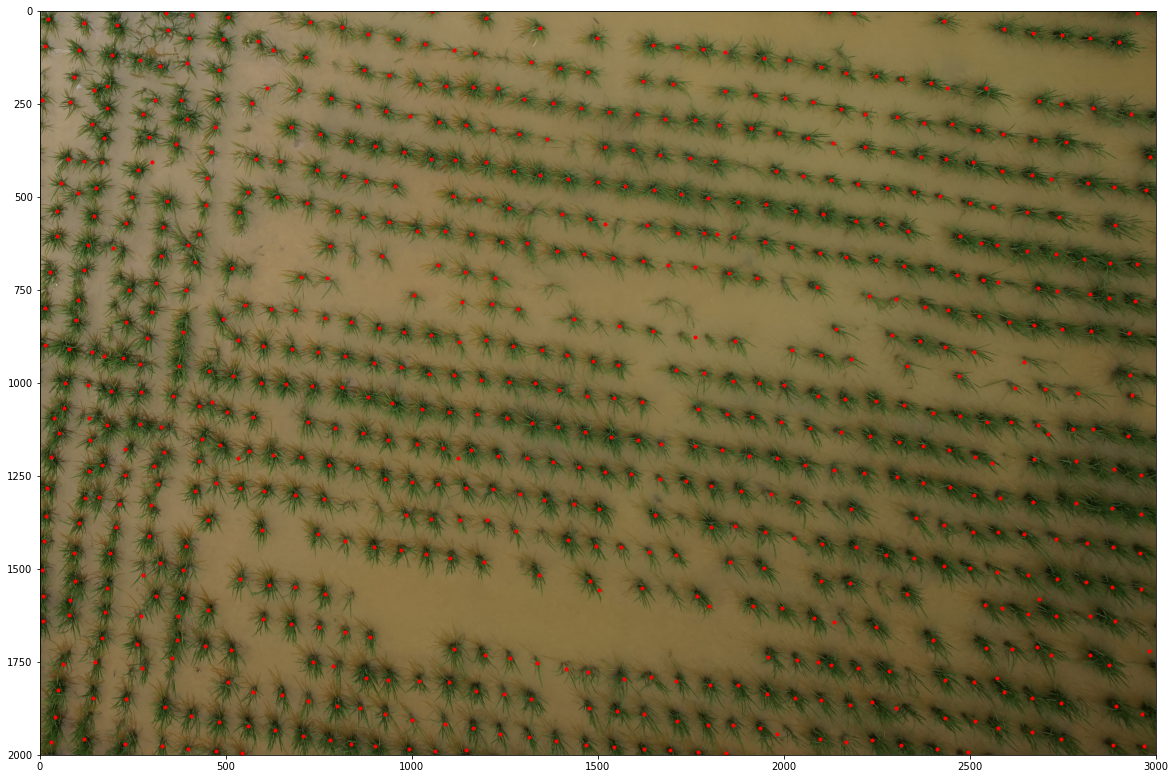

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(img)
reduction_mids = reduction(cluster_mids, thresh=30)
for cluster_mid in reduction_mids:
  plt.plot(cluster_mid[0], cluster_mid[1], 'r.')
# for point in ground_truth:
  # plt.plot(point[0], point[1], 'c+')

# for i in range(0, 2000, 200):
#   plt.hlines(i, 0,3000)

# for j in range(0, 3000, 150):
#   plt.vlines(j, 0, 2000)

plt.xlim([0, 3000])
plt.ylim([2000, 0])

with open('./answer.csv', 'w') as fout:
  for cluster_mid in reduction_mids:
    fout.write('{}, {}\n'.format(*cluster_mid))

(2000.0, 0.0)

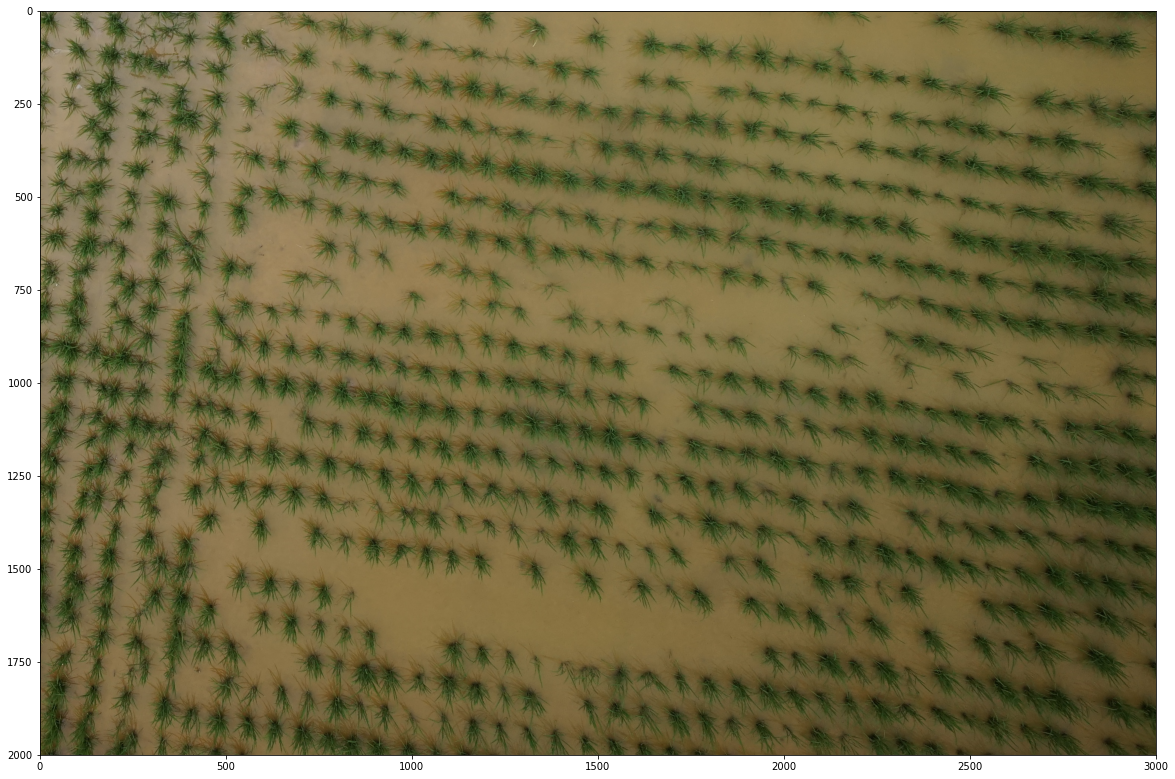

In [ ]:
stride = (100,100)

demo_img = Image.open(selected_path)
result_map = np.zeros(demo_img.size[::-1])

plt.figure(figsize=(20,20))

C = torch.load('/content/best224.pt')
C.eval()

for i in range(0, demo_img.size[0], stride[0]):
  for j in range(0, demo_img.size[1], stride[1]):
    
    input_img = demo_img.crop((i,j,i+stride[0],j+stride[1]))
    input_img = TF.resize(input_img, [224, 224])
    input_img = TF.pil_to_tensor(input_img).float()

    outputs = C(input_img.unsqueeze(0).to(device))
    _, predicted = torch.max(outputs, 1)
    result_map[j:j+stride[1], i:i+stride[0]] = predicted.cpu()
    # print(i,j)

    if predicted.cpu() == 1:
      for cluster_mid in reduction_mids:
        if cluster_mid[0] < i + stride[0] and cluster_mid[0] >= i and cluster_mid[1] < j + stride[1] and cluster_mid[1] >= j:
          plt.plot(*cluster_mid, 'r+')

plt.imshow(demo_img)
# plt.imshow(result_map, alpha=0.3)

# for i in range(0, demo_img.size[0], stride[0]):
#   plt.vlines(i, 0, 2000)

# for j in range(0, demo_img.size[1], stride[1]):
#   plt.hlines(j, 0, 3000)

plt.xlim(0, 3000)
plt.ylim(2000, 0)